# Functional Identicality (FI): End-to-End Pipeline

This notebook shows the full FI pipeline for a single dataset (here: `Cowrie.csv`).

The steps are:

1. Set up the project root and import the `fi_fs` module.
2. Load the aggregated session-level dataset.
3. Parse command strings into ordered `(op, args, conn)` triplets.
4. Normalise the sequences (aliases, placeholders, α-renumbering).
5. Build the FI table (canonical serialisation + hash).
6. Select one FI-unique archetype per FI class and write it to disk.

The goal is to make it easy to see **what FI does** from start to finish.

In [1]:
# 1) Setup: project root and imports

import sys
import subprocess
from pathlib import Path
import json
import shutil

import pandas as pd
from IPython.display import display

# Find the git repository root and ensure src/ is on sys.path
ROOT = Path(
    subprocess.check_output(
        ["git", "rev-parse", "--show-toplevel"],
        text=True,
    ).strip()
)
sys.path[:0] = [str(ROOT / "src")]

print("Project ROOT (name):", ROOT.name)
print("Using src directory: 'src'")

from fi_fs import (
    load_aggregated_csv,
    parse_dataframe_to_triplets,
    apply_aliases,
    apply_placeholders_args_only,
    assert_connectors_preserved,
    alpha_renumber,
    assert_serialisation_deterministic,
    build_fi_dataframe,
    write_fi_csv,
    load_alias_map_yaml,
)

Project ROOT (name): PhD
Using src directory: 'src'
PYTHON: cpython 3.12.0
BASHLEX: 0.18


## Step 1 - Select dataset and define output paths

Here we choose the input dataset (an aggregated CSV with one row per session)
and define where FI outputs will be written.

- Input: `projects/fi_fs/data/processed/Cowrie.csv`
- Output directory: `projects/fi_fs/data/output/Cowrie/`


In [2]:
# 2) Dataset configuration and output directories

DATASET = "Cowrie.csv"  # change here to run FI on other datasets

INPUT_DATASET = ROOT / "projects" / "fi_fs" / "data" / "processed" / DATASET
DATASET_NAME = INPUT_DATASET.stem  # "Cowrie"

OUTPUT_DIR = ROOT / "projects" / "fi_fs" / "data" / "output" / DATASET_NAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Input dataset:", INPUT_DATASET.relative_to(ROOT))
print("Output directory:", OUTPUT_DIR.relative_to(ROOT))


Input dataset: projects/fi_fs/data/processed/Cowrie.csv
Output directory: projects/fi_fs/data/output/Cowrie


## Step 2 - Load aggregated session data

The helper `load_aggregated_csv`:

- Reads the aggregated CSV,
- Returns a dataframe (`agg`) with one row per session,
- Returns a small `stats` dict (number of sessions, min/median/max rows).

This step checks that the dataset looks as expected before parsing.


In [3]:
# 3) Load aggregated sessions

agg, stats = load_aggregated_csv(str(INPUT_DATASET))

print("\n--- FI Pipeline: Stage 1 - Data loading ---")
print("Sessions:", stats["n_sessions"])
print("Rows per session (min/median/max):",
      stats["n_rows_min"], stats["n_rows_med"], stats["n_rows_max"])

print("\nAggregated dataframe columns:")
print(list(agg.columns))

display(agg.head(5))



--- FI Pipeline: Stage 1 - Data loading ---
Sessions: 63039
Rows per session (min/median/max): 1 4 105

Aggregated dataframe columns:
['session', 'n_rows', 'commands_joined']


,session,n_rows,commands_joined
0,00031aeff1a6,5,sh\nshell\nenable\necho 'nameserver 95.214.27....
1,0003e7887230,5,sh\nshell\nenable\necho 'nameserver 95.214.27....
2,0003f10a2103,4,sh\nshell\nenable\ncat /bin/echo || while read...
3,0009b3b635ed,1,cat /bin/echo
4,000b5a1e7c5f,1,echo -e '\\x67\\x61\\x79\\x66\\x67\\x74'


## Step 3 - Parse into `(op, args, conn)` sequences

This step uses `bashlex` under the hood (via `parse_dataframe_to_triplets`)
to turn each session’s command string into an ordered sequence of:

- operator (`op`)
- arguments (`args`)
- connector (`conn`) such as `;`, `&&`, `||`, or `|`

Parsing is order-aware and preserves connectors/dataflow. Any parse problems
are recorded for inspection.


In [4]:
# 4) Parse sessions into triplet sequences

seqs, parsed_parts, parse_df, problems = parse_dataframe_to_triplets(
    agg,
    progress=True,
    with_diagnostics=True,
)

print("\n--- FI Pipeline: Stage 2 - Bashlex parsing ---")
print("Sequences built:", len(seqs))
print("Parsed rows (parse_df shape):", parse_df.shape)

if problems:
    print("\nParsing problems encountered:", len(problems))
    print("First few problems:")
    for p in problems[:5]:
        print(" -", p)
else:
    print("\nNo parsing problems recorded.")


Parsing sessions (bashlex): 100%|██████████| 63039/63039 [00:44<00:00, 1405.59it/s]



--- FI Pipeline: Stage 2 - Bashlex parsing ---
Sequences built: 63039
Parsed rows (parse_df shape): (63039, 4)

Parsing problems encountered: 19536
First few problems:
 - ('00031aeff1a6', {';': 2, '&&': 0, '||': 1, '|': 0}, {';': 1, '&&': 0, '||': 1, '|': 0}, 4)
 - ('0003e7887230', {';': 2, '&&': 0, '||': 1, '|': 0}, {';': 1, '&&': 0, '||': 1, '|': 0}, 4)
 - ('0003f10a2103', {';': 2, '&&': 0, '||': 1, '|': 0}, {';': 1, '&&': 0, '||': 1, '|': 0}, 3)
 - ('000cd6e3c127', {';': 2, '&&': 0, '||': 1, '|': 0}, {';': 1, '&&': 0, '||': 1, '|': 0}, 3)
 - ('0019ca550acd', {';': 2, '&&': 0, '||': 1, '|': 0}, {';': 1, '&&': 0, '||': 1, '|': 0}, 3)


## Step 4 - Normalisation and α-renumbering

Normalisation applies three key operations:

1. **Alias map** - map near-equivalent utilities to a canonical operator
   using `alias_map.yaml` (e.g. `wget` ↔ `curl -O` under matching flags).

2. **Placeholders** - replace instance-specific arguments (IPs, URLs,
   paths, etc.) with typed placeholders such as `<IP_1>`, `<PATH_2>`.
   Connectors must remain unchanged.

3. **α-renumbering** - renumber placeholders in order of first use to
   make the canonical representation deterministic across sessions.

After this step, we have canonicalised sequences ready for FI.


In [5]:
# 5) Normalisation: aliases → placeholders → α-renumber

print("\n--- FI Pipeline: Stage 3 – Normalisation ---")

# 5.1 Load alias map
alias_map_path = ROOT / "src" / "fi_fs" / "resources" / "alias_map.yaml"
alias_map = load_alias_map_yaml(alias_map_path)
print("Loaded alias map from:", alias_map_path.relative_to(ROOT))

# 5.2 Apply alias map
seqs_alias, alias_changes = apply_aliases(seqs, alias_map)
n_alias_changes = 0 if alias_changes is None else len(alias_changes)
print("Alias changes recorded:", n_alias_changes)

# 5.3 Apply placeholders to arguments only
seqs_ph, dbg = apply_placeholders_args_only(
    seqs_alias,
    debug=True,
    preview_changed_first_n_sessions=5,
    sample_per_reason=5,
)

# Sanity check: connectors should be unchanged by placeholder logic
assert_connectors_preserved(seqs_alias, seqs_ph)
print("Connectors preserved after placeholder substitution.")

# 5.4 α-renumber placeholders to ensure deterministic naming
seqs_alpha = alpha_renumber(seqs_ph, check_idempotent=True)

# seqs_alpha is typically a dict: {session_id: [(op, args, conn), ...], ...}
print("α-renumbered sessions:", len(seqs_alpha))

# Optional: quick look at one canonicalised sequence
print("\nExample canonicalised sequence:")

if isinstance(seqs_alpha, dict) and len(seqs_alpha) > 0:
    example_session = next(iter(seqs_alpha.keys()))
    print("Example session key:", example_session)
    print("Sequence:")
    print(seqs_alpha[example_session])
elif hasattr(seqs_alpha, "__len__") and len(seqs_alpha) > 0:
    # Fallback in case it's a list-like
    print(seqs_alpha[0])
else:
    print("No sequences available to display.")



--- FI Pipeline: Stage 3 – Normalisation ---
Loaded alias map from: src/fi_fs/resources/alias_map.yaml
Alias changes recorded: 163
Connectors preserved after placeholder substitution.
α-renumbered sessions: 63039

Example canonicalised sequence:
Example session key: 00031aeff1a6
Sequence:
[('sh', [], ';'), ('shell', [], ';'), ('enable', [], ';'), ('echo', ['PH_ECHO_TXT', '>', 'PH_PATH_1'], ';'), ('cat', ['PH_PATH_2'], '||'), ('read', ['i'], ';'), ('echo', ['$i'], 'EOS')]


## Step 5 - Build FI table (canonical JSON + hash)

We now:

1. Check that serialisation is deterministic.
2. Build a FI dataframe by joining the canonical sequences back with the
   session metadata.
3. Write a canonical FI CSV with:

   - One row per session,
   - Canonical JSON representation,
   - `fi_hash` (SHA-256 over the canonical JSON),
   - `n_rows`, commands column, and any other metadata.

The `fi_hash` acts as a **stable FI-class identifier**.


In [6]:
# 6) Build FI table and write canonical CSV

print("\n--- FI Pipeline: Stage 4 - FI table ---")

# 6.1 Ensure canonical serialisation is deterministic
assert_serialisation_deterministic(seqs_alpha)
print("Serialisation is deterministic.")

# 6.2 Build FI dataframe
fi_df = build_fi_dataframe(
    agg,
    seqs_alpha,
    commands_col="commands_joined",  # adjust if column name differs
)

print("FI dataframe shape:", fi_df.shape)
print("FI dataframe columns:", list(fi_df.columns))

display(fi_df.head(5))

# 6.3 Write canonical FI CSV (fi_df) and move to data/output/<dataset>/
out_csv_str = write_fi_csv(fi_df, str(INPUT_DATASET))
out_csv = Path(out_csv_str)
if not out_csv.is_absolute():
    out_csv = Path.cwd() / out_csv

final_canonical_path = OUTPUT_DIR / out_csv.name
shutil.move(str(out_csv), final_canonical_path)

print("\nWrote canonical FI CSV to:",
      final_canonical_path.relative_to(ROOT))



--- FI Pipeline: Stage 4 - FI table ---
Serialisation is deterministic.
FI dataframe shape: (63039, 5)
FI dataframe columns: ['session', 'n_rows', 'fi_hash', 'commands_clean', 'canonical_json']


,session,n_rows,fi_hash,commands_clean,canonical_json
0,00031aeff1a6,5,9c07a2ac9b0db760,sh\nshell\nenable\necho 'nameserver 95.214.27....,"[[""sh"",[],"";""],[""shell"",[],"";""],[""enable"",[],""..."
1,0003e7887230,5,9c07a2ac9b0db760,sh\nshell\nenable\necho 'nameserver 95.214.27....,"[[""sh"",[],"";""],[""shell"",[],"";""],[""enable"",[],""..."
2,0003f10a2103,4,ec2785b8610be5a7,sh\nshell\nenable\ncat /bin/echo || while read...,"[[""sh"",[],"";""],[""shell"",[],"";""],[""enable"",[],""..."
3,0009b3b635ed,1,a34d629a02c11268,cat /bin/echo,"[[""cat"",[""PH_PATH_1""],""EOS""]]"
4,000b5a1e7c5f,1,a5b2e002ac0fcb8a,echo -e '\\x67\\x61\\x79\\x66\\x67\\x74',"[[""echo"",[""-e"",""PH_HEXDATA""],""EOS""]]"



Wrote canonical FI CSV to: projects/fi_fs/data/output/Cowrie/Cowrie_canonical.csv


## Step 6 - FI-unique archetypes (one per `fi_hash`)

Each FI class groups sessions that are **functionally identical** after
normalisation.

Here we:

1. Count how many sessions fall into each FI class.
2. Select a **deterministic representative** per `fi_hash`:
   - Longest `n_rows` first (most complete behaviour),
   - Ties broken by session id.

3. Save one row per FI class to
   `*_canonical__FI_representatives_with_singleton.csv`, including:

   - `fi_hash`
   - `n_classes` (class size)
   - `singleton` flag
   - `commands_clean`
   - `canonical_json`


In [7]:
# 7) Select FI-unique archetypes and write representatives CSV

print("\n--- FI Pipeline: Stage 5 - FI-unique archetypes ---")

# 7.1 Detect which commands column FI gave us
CMD_CANDIDATES = ["commands_clean", "commands_joined", "commands"]
cmd_col = next((c for c in CMD_CANDIDATES if c in fi_df.columns), None)
if cmd_col is None:
    raise KeyError(
        f"None of {CMD_CANDIDATES} found in fi_df.columns={list(fi_df.columns)}"
    )

print(f"Using '{cmd_col}' as commands column for archetypes.")

# 7.2 How many sessions per FI class?
class_sizes = (
    fi_df.groupby("fi_hash")["session"]
         .size()
         .rename("n_classes")
         .reset_index()
)

# 7.3 Deterministic representative per fi_hash:
#     - longest n_rows (descending)
#     - tie-break by session id (ascending)
fi_sorted = (
    fi_df.sort_values(["n_rows", "session"], ascending=[False, True])
         .merge(class_sizes, on="fi_hash", how="left")
)

archetypes = (
    fi_sorted
      .drop_duplicates("fi_hash", keep="first")
      .assign(singleton=lambda df: df["n_classes"] == 1)
      [["session", "n_rows", "fi_hash", "singleton", "n_classes",
        cmd_col, "canonical_json"]]
      .rename(columns={cmd_col: "commands_clean"})
      .reset_index(drop=True)
)

print("Number of FI classes (archetypes):", len(archetypes))
print("Singleton FI classes:", int(archetypes["singleton"].sum()))

display(archetypes.head(5))

# 7.4 Write representatives CSV
rep_out = final_canonical_path.with_name(
    final_canonical_path.stem + "__FI_representatives_with_singleton" + final_canonical_path.suffix
)
rep_for_csv = archetypes[[
    "session", "n_rows", "fi_hash",
    "singleton", "n_classes",
    "commands_clean", "canonical_json",
]]
rep_for_csv.to_csv(rep_out, index=False)

print("Wrote FI representatives CSV to:", rep_out.relative_to(ROOT))



--- FI Pipeline: Stage 5 - FI-unique archetypes ---
Using 'commands_clean' as commands column for archetypes.
Number of FI classes (archetypes): 418
Singleton FI classes: 146


,session,n_rows,fi_hash,singleton,n_classes,commands_clean,canonical_json
0,47134c0c4dce,105,849ac220bcb28000,True,1,echo\nid\nshow version\necho\nid\nshow version...,"[[""echo"",[],"";""],[""id"",[],"";""],[""show"",[""versi..."
1,032039c09cf5,72,7fef9be56d5dd1a7,False,9,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",..."
2,0345ed3fbf9d,72,2f587720e0e4fa7c,False,5,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",..."
3,1ef53df25795,72,68d07b56fce54f05,False,7,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",..."
4,27d0b57dc6c8,72,ecc94dc717f32c91,False,10,enable\nsystem\nshell\nsh\nlinuxshell\ncd /tmp...,"[[""enable"",[],"";""],[""system"",[],"";""],[""shell"",..."


Wrote FI representatives CSV to: projects/fi_fs/data/output/Cowrie/Cowrie_canonical__FI_representatives_with_singleton.csv


## (Optional) Step 7 - Quick summary

This cell summarises:

- Total raw sessions,
- Number of FI classes (archetypes),
- Fraction of singleton vs non-singleton classes.

This gives a quick sense of how much duplication FI removes.


In [8]:
# 8) Summary statistics for FI

n_sessions = len(fi_df)
n_classes = len(archetypes)
n_singletons = int(archetypes["singleton"].sum())
n_non_singletons = n_classes - n_singletons

print("\n--- FI Summary ---")
print(f"Raw sessions:          {n_sessions}")
print(f"FI classes (archetypes): {n_classes}")
print(f"Singleton classes:     {n_singletons}")
print(f"Non-singleton classes: {n_non_singletons}")

dedup_factor = n_sessions / n_classes if n_classes > 0 else float("nan")
print(f"Average sessions per FI class: {n_sessions / n_classes:.2f}"
      if n_classes > 0 else "N/A")
print(f"Deduplication factor (sessions / FI classes): {dedup_factor:.2f}"
      if n_classes > 0 else "N/A")



--- FI Summary ---
Raw sessions:          63039
FI classes (archetypes): 418
Singleton classes:     146
Non-singleton classes: 272
Average sessions per FI class: 150.81
Deduplication factor (sessions / FI classes): 150.81


## FI Overview – Visual Summary

To understand the effect of FI on the dataset, we visualise:

1. Largest FI classes.
2. Top operators used across all sessions (weighted by FI class size).
3. Connector usage across sessions (weighted by FI class size).
4. Operator diversity vs FI class size.

These plots give an intuitive feel for duplication and the structure of the FI classes.


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Just to make sure plots render inline in the notebook
%matplotlib inline


### 1. Largest FI classes

Finally, we inspect the largest FI classes to see highly repeated
behaviours.

We show a bar chart of the top 10 FI classes by `n_classes`, and
print a small table with their hashes and representative commands.


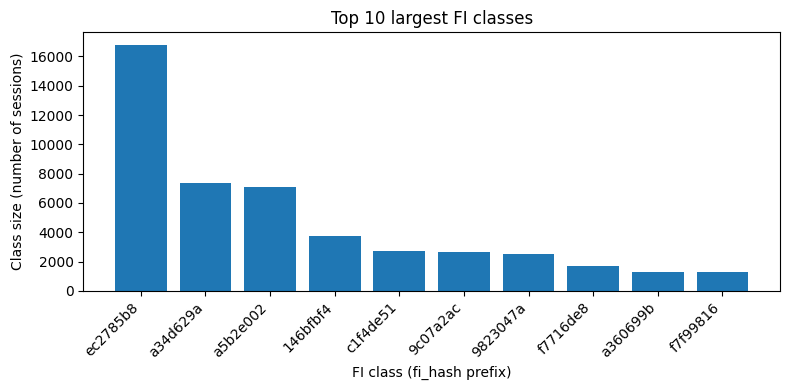

Top 10 FI classes (by size):


,fi_hash,n_classes,n_rows,commands_clean
148,ec2785b8610be5a7,16807,4,sh\nshell\nenable\ncat /bin/echo || while read...
225,a34d629a02c11268,7376,1,cat /bin/echo
226,a5b2e002ac0fcb8a,7071,1,echo -e '\\x67\\x61\\x79\\x66\\x67\\x74'
227,146bfbf4066fd438,3734,1,uname -a
228,c1f4de5103d6ebc1,2750,1,uname -s -v -n -r -m
127,9c07a2ac9b0db760,2647,5,sh\nshell\nenable\necho 'nameserver 95.214.27....
194,9823047ab95dbd47,2506,2,echo -e '\\x67\\x61\\x79\\x66\\x67\\x74'\necho...
197,f7716de87b7f40be,1717,2,"cd ~ && rm -rf .ssh && mkdir .ssh && echo ""ssh..."
170,a360699b5640cf35,1298,3,ifconfig\nuname -a\ncat /proc/cpuinfo
116,f7f99816e8b68be2,1288,6,cat /bin/echo\ncat /proc/mounts\necho -e '\\x7...


In [10]:
# 1) Top 10 largest FI classes

top_k = 10
top_classes = (
    archetypes.sort_values("n_classes", ascending=False)
              .head(top_k)
)

plt.figure(figsize=(8, 4))
x_positions = np.arange(len(top_classes))
plt.bar(x_positions, top_classes["n_classes"])
plt.xticks(
    x_positions,
    [h[:8] for h in top_classes["fi_hash"]],  # short hash prefix
    rotation=45,
    ha="right",
)
plt.xlabel("FI class (fi_hash prefix)")
plt.ylabel("Class size (number of sessions)")
plt.title(f"Top {top_k} largest FI classes")
plt.tight_layout()
plt.show()

print(f"Top {top_k} FI classes (by size):")
display(
    top_classes[
        ["fi_hash", "n_classes", "n_rows", "commands_clean"]
    ]
)


In [11]:
import json
from collections import Counter

def decode_canonical(canon_json: str):
    """
    canonical_json: JSON like [["op", ["arg1","arg2"], "conn"], ...]
    returns: list[(op:str, args:tuple[str,...], conn:str)]
    """
    rows = json.loads(canon_json)
    return [(op, tuple(args), conn) for op, args, conn in rows]

# Attach decoded sequences to archetypes for convenience (if not already present)
if "seq" not in archetypes.columns:
    archetypes["seq"] = archetypes["canonical_json"].map(decode_canonical)

print("Decoded canonical sequences for archetypes.")


Decoded canonical sequences for archetypes.


### 2. Top operators across sessions

This plot shows the most common operators (commands) across **all sessions**, after FI deduplication.
Each operator’s count is weighted by the size of the FI class it belongs to (`n_classes`), so it reflects how often that behaviour appears in the original corpus.


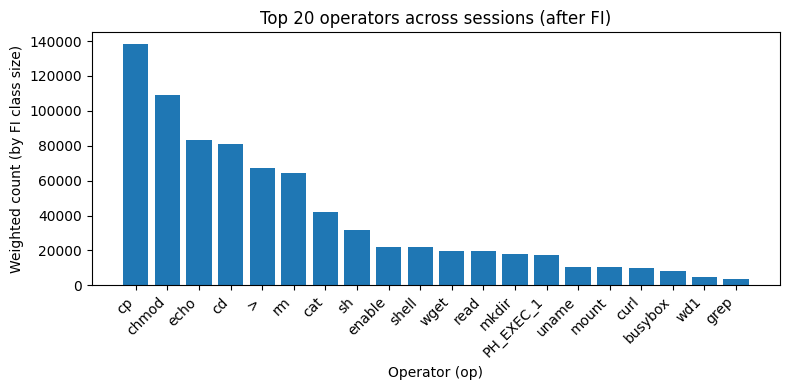

Top operators (weighted by FI class size):
cp              138079
chmod           108938
echo            83437
cd              81163
>               67130
rm              64409
cat             42142
sh              31807
enable          22093
shell           22077
wget            19950
read            19536
mkdir           17908
PH_EXEC_1       17692
uname           10421
mount           10366
curl            9909
busybox         8045
wd1             4894
grep            3458


In [12]:
# 2) Count operators weighted by FI class size

op_counts_sessions = Counter()

for _, row in archetypes.iterrows():
    n = int(row["n_classes"])        # how many sessions in this FI class
    seq = row["seq"]                 # list of (op, args, conn)
    for op, args, conn in seq:
        op_counts_sessions[op] += n  # weight by number of sessions

top_k_ops = 20
top_ops = op_counts_sessions.most_common(top_k_ops)

labels = [op for op, _ in top_ops]
values = [count for _, count in top_ops]

plt.figure(figsize=(8, 4))
x_positions = range(len(labels))
plt.bar(x_positions, values)
plt.xticks(x_positions, labels, rotation=45, ha="right")
plt.xlabel("Operator (op)")
plt.ylabel("Weighted count (by FI class size)")
plt.title(f"Top {top_k_ops} operators across sessions (after FI)")
plt.tight_layout()
plt.show()

print("Top operators (weighted by FI class size):")
for op, count in top_ops:
    print(f"{op:15s} {count}")


### 3. Connector usage across sessions

Connectors capture control and data flow: sequencing (`;`), short-circuit AND
(`&&`), OR (`||`), pipes (`|`), etc.

Here we count connectors, again weighted by FI class size, to see how scripts
are typically chained.


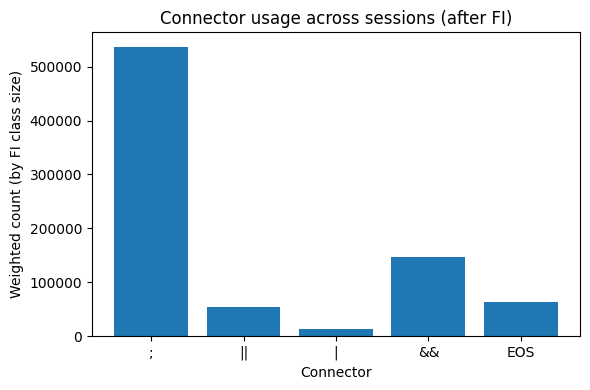

Connector counts (weighted by FI class size):
';'      536702
'||'     54388
'|'      12667
'&&'     147335
'EOS'    63039


In [13]:
# 3) Count connectors weighted by FI class size

conn_counts_sessions = Counter()

for _, row in archetypes.iterrows():
    n = int(row["n_classes"])
    seq = row["seq"]
    for op, args, conn in seq:
        conn_counts_sessions[conn] += n

# In the event of an end-of-sequence marker ("∎"), we can ignore it here
if "∎" in conn_counts_sessions:
    pass  # or: del conn_counts_sessions["∎"]

labels = list(conn_counts_sessions.keys())
values = [conn_counts_sessions[c] for c in labels]

plt.figure(figsize=(6, 4))
x_positions = range(len(labels))
plt.bar(x_positions, values)
plt.xticks(x_positions, labels)
plt.xlabel("Connector")
plt.ylabel("Weighted count (by FI class size)")
plt.title("Connector usage across sessions (after FI)")
plt.tight_layout()
plt.show()

print("Connector counts (weighted by FI class size):")
for conn, count in conn_counts_sessions.items():
    print(f"{repr(conn):8s} {count}")


### 4. Operator diversity vs FI class size

Each point is an FI class (archetype):

- x-axis: number of **unique operators** used in the canonical sequence,
- y-axis: how many sessions belong to that FI class (`n_classes`).

This gives a quick sense of whether simple behaviours (few operators) or
richer behaviours (many operators) are more widely reused.


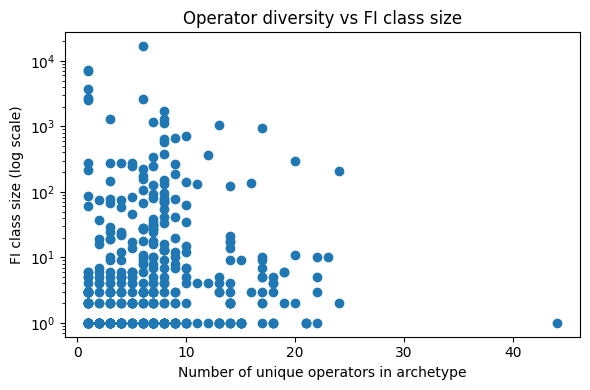

Unique operators per archetype – summary:


,n_unique_ops,n_classes
count,418.000000,418.000000
mean,7.126794,150.811005
std,5.416088,1011.112648
min,1.000000,1.000000
25%,3.000000,1.000000
50%,6.000000,3.000000
75%,9.000000,13.000000
max,44.000000,16807.000000


In [14]:
# 4) Operator diversity vs FI class size

if "n_unique_ops" not in archetypes.columns:
    archetypes["n_unique_ops"] = archetypes["seq"].map(
        lambda seq: len({op for op, args, conn in seq})
    )

plt.figure(figsize=(6, 4))
plt.scatter(archetypes["n_unique_ops"], archetypes["n_classes"])
plt.yscale("log")  # FI class sizes often have a long tail
plt.xlabel("Number of unique operators in archetype")
plt.ylabel("FI class size (log scale)")
plt.title("Operator diversity vs FI class size")
plt.tight_layout()
plt.show()

print("Unique operators per archetype – summary:")
display(archetypes[["n_unique_ops", "n_classes"]].describe())
